# PyTorch Custom Dataset Notebook

## 0. Importing PyTorch and Setting Up Device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.4.1+cu121'

In [2]:
# Setting device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Wed Jan 15 08:09:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             24W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get Data

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a writable data folder
data_path = Path('/kaggle/working/')
image_path = data_path / 'pizza-steak-sushi'

if image_path.is_dir():
    print(f'{image_path} directory already exists ...')
else:
    print(f'{image_path} does not exist, creating one ...')
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, and sushi data
    zip_file_path = data_path / 'pizza_steak_sushi.zip'
    with open(zip_file_path, 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
        f.write(request.content)
    
    # Unzip pizza, steak, and sushi data
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(image_path)
    
    print(f"Data downloaded and extracted to {image_path}.")

/kaggle/working/pizza-steak-sushi does not exist, creating one ...
Data downloaded and extracted to /kaggle/working/pizza-steak-sushi.


## 2. Data Preparation and Exploration

In [5]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in /kaggle/working/pizza-steak-sushi
There are 3 directories and 0 images in /kaggle/working/pizza-steak-sushi/test
There are 0 directories and 19 images in /kaggle/working/pizza-steak-sushi/test/steak
There are 0 directories and 25 images in /kaggle/working/pizza-steak-sushi/test/pizza
There are 0 directories and 31 images in /kaggle/working/pizza-steak-sushi/test/sushi
There are 3 directories and 0 images in /kaggle/working/pizza-steak-sushi/train
There are 0 directories and 75 images in /kaggle/working/pizza-steak-sushi/train/steak
There are 0 directories and 78 images in /kaggle/working/pizza-steak-sushi/train/pizza
There are 0 directories and 72 images in /kaggle/working/pizza-steak-sushi/train/sushi


In [7]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('/kaggle/working/pizza-steak-sushi/train'),
 PosixPath('/kaggle/working/pizza-steak-sushi/test'))

### 2.1 Visualising and image

Random image path: /kaggle/working/pizza-steak-sushi/test/sushi/2385731.jpg
Image class: sushi
Image height: 512
Image width: 512


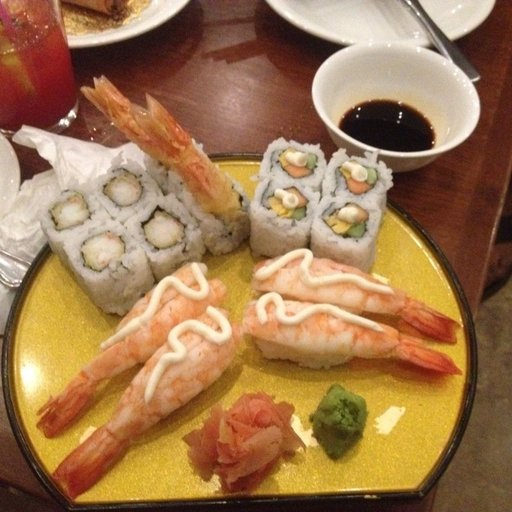

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')

img

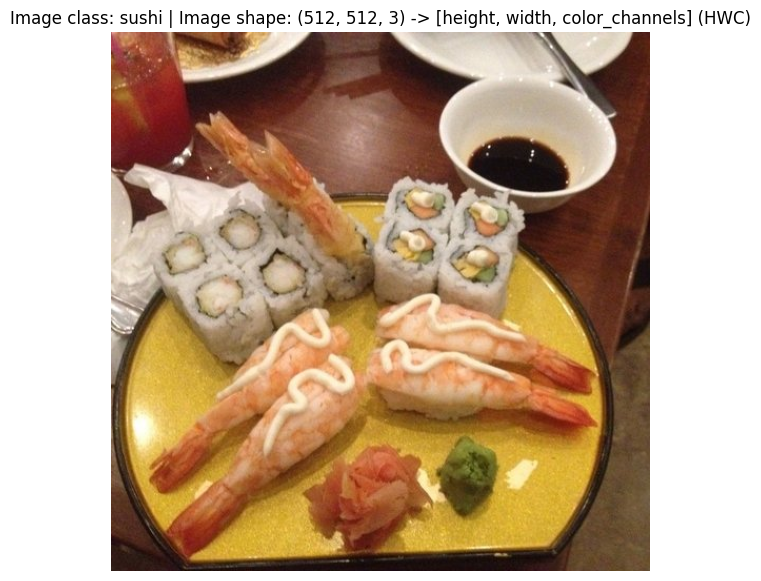

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)')
plt.axis(False);

In [10]:
img_as_array

array([[[187, 112, 116],
        [235, 161, 160],
        [231, 158, 151],
        ...,
        [ 75,  27,  23],
        [ 79,  31,  27],
        [ 82,  34,  30]],

       [[179, 103, 107],
        [220, 146, 145],
        [217, 142, 136],
        ...,
        [ 75,  27,  23],
        [ 76,  28,  24],
        [ 78,  30,  26]],

       [[171,  92,  97],
        [200, 124, 124],
        [203, 126, 120],
        ...,
        [ 78,  29,  24],
        [ 78,  29,  24],
        [ 79,  30,  25]],

       ...,

       [[ 54,  37,  30],
        [ 52,  35,  28],
        [ 51,  32,  26],
        ...,
        [101,  80,  51],
        [106,  85,  56],
        [110,  89,  60]],

       [[ 51,  34,  27],
        [ 50,  33,  26],
        [ 48,  31,  24],
        ...,
        [ 99,  78,  51],
        [105,  84,  57],
        [110,  90,  63]],

       [[ 47,  30,  23],
        [ 47,  30,  23],
        [ 46,  29,  22],
        ...,
        [ 98,  77,  50],
        [100,  80,  55],
        [105,  85,  60]]

## 3. Transforming data

Before we can use our image data with PyTorch
1. Turn the target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [11]:
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.tranforms`

In [12]:
# Write a transform for image
data_transform = transforms.Compose([
    
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    
    # Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [13]:
data_transform(img)

tensor([[[0.7373, 0.7686, 0.7529,  ..., 0.7216, 0.3255, 0.3176],
         [0.6784, 0.7255, 0.7098,  ..., 0.4941, 0.3020, 0.3294],
         [0.6000, 0.5961, 0.6000,  ..., 0.2980, 0.2980, 0.3216],
         ...,
         [0.1843, 0.2157, 0.1922,  ..., 0.4235, 0.4275, 0.4157],
         [0.1882, 0.1804, 0.1804,  ..., 0.4235, 0.4275, 0.4157],
         [0.1843, 0.1882, 0.1804,  ..., 0.4157, 0.4275, 0.4157]],

        [[0.4275, 0.5098, 0.4824,  ..., 0.6314, 0.1608, 0.1255],
         [0.3098, 0.4314, 0.4078,  ..., 0.3647, 0.1294, 0.1373],
         [0.2667, 0.2941, 0.3255,  ..., 0.1451, 0.1216, 0.1333],
         ...,
         [0.1020, 0.1294, 0.1098,  ..., 0.3255, 0.3412, 0.3294],
         [0.1020, 0.1059, 0.1098,  ..., 0.3176, 0.3216, 0.3216],
         [0.1098, 0.1020, 0.0941,  ..., 0.3176, 0.3176, 0.3137]],

        [[0.3765, 0.3686, 0.3412,  ..., 0.5647, 0.1137, 0.0863],
         [0.3294, 0.3216, 0.2667,  ..., 0.3098, 0.0745, 0.0706],
         [0.2706, 0.2627, 0.2275,  ..., 0.1020, 0.0863, 0.

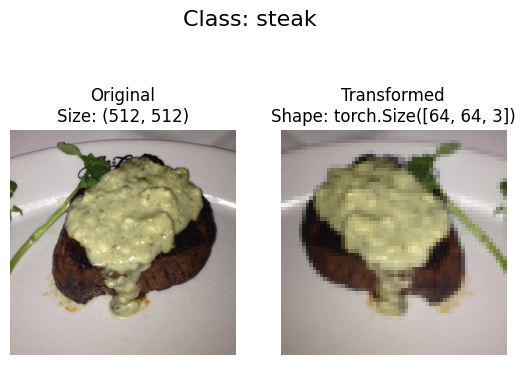

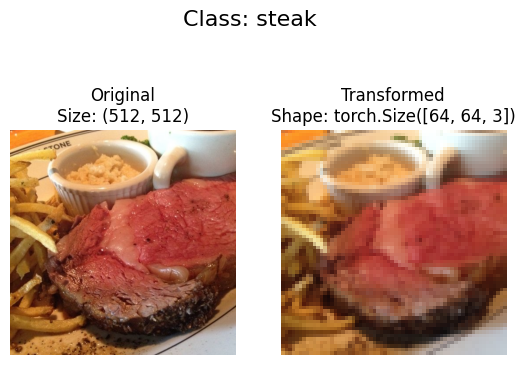

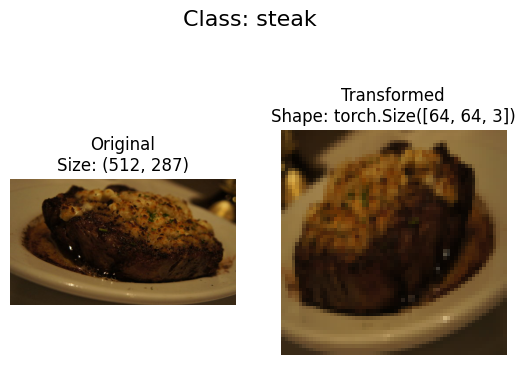

In [14]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms 
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

In [15]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: /kaggle/working/pizza-steak-sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: /kaggle/working/pizza-steak-sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
# Get class names as a list
class_names = train_data.classes
print(class_names)

# Get class names as a dict
class_dict = train_data.class_to_idx
print(class_dict)

# Check the lengths of our dataset
print(len(train_data), len(test_data))

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
225 75


In [17]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor:\n {img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Label datatype: {type(label)}')

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]); Image permute: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

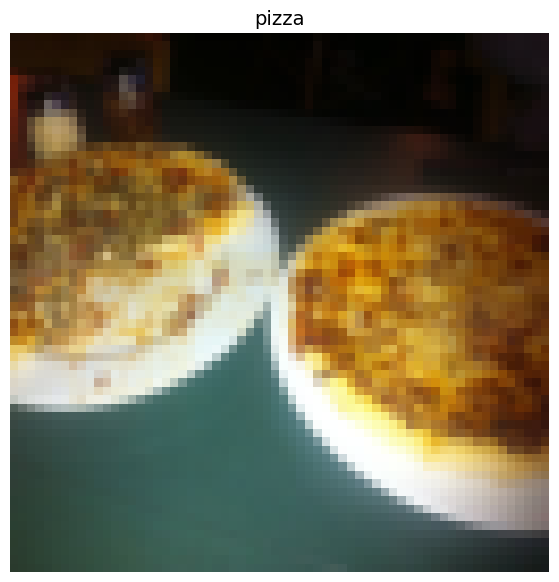

In [18]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f'Original shape: {img.shape}; Image permute: {img_permute.shape}')

# plot the Image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded image into `DataLoader`'s

In [19]:
!nvidia-smi

Wed Jan 15 08:10:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             24W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
import os
os.cpu_count()

4

In [21]:
# Turn train and test datsets into DataLoader's 
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=1, 
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x787a399d8b80>,
 <torch.utils.data.dataloader.DataLoader at 0x787a3995edd0>)

In [22]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [23]:
img, label = next(iter(train_dataloader))
print(f'Image shape: {img.shape}')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

In [24]:
import os 
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
# Instance of torchvision.dataset.ImageFolder()

train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [26]:
# Setup path for target directory
target_directory = train_dir
print(f'Target dir: {target_directory}')

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: /kaggle/working/pizza-steak-sushi/train


['pizza', 'steak', 'sushi']

In [27]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'pizza'>, <DirEntry 'sushi'>]

In [28]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, breakpoint]]:
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class could not be found
    if not classes:
        raise FileNotFoundError(f'Could not find any classes in {directory}')

    # 3. Create a dictionary of index labels 
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [29]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [30]:
# Custom dataset class
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform=None):
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [31]:
img, label = train_data[0]
img, label

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [32]:
# Create transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [33]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

### 5.3 Create a function to display random images

In [34]:
# Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset, 
                          classes: List[str] = None, 
                          n: int = 10, 
                          display_shape: bool = True, 
                          seed: int = None):
    
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f'n should NOT be larger than 10')

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Set plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor ddimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)
    
        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f'Class: {classes[targ_label]}'
            if display_shape:
                title = title + f'\nShape: {targ_image_adjust.shape}'
    
        plt.title(title)

In [35]:
random.sample(range(len(train_data)), k=10)

[57, 35, 188, 26, 173, 189, 139, 22, 151, 108]

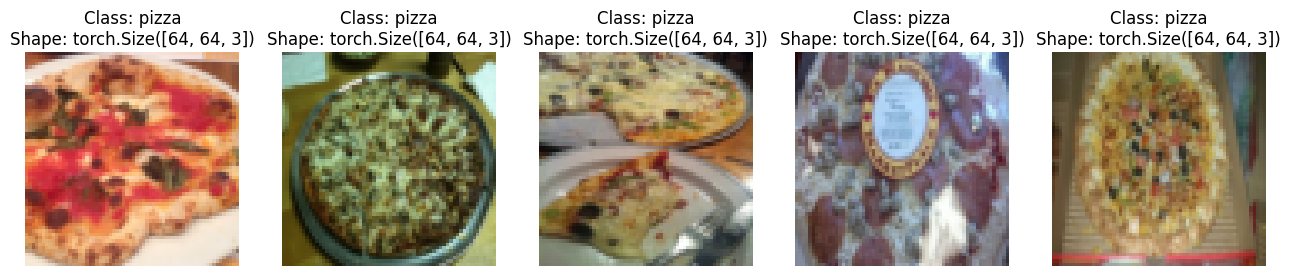

In [36]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data, n=5,
                     classes=class_names, seed=None)

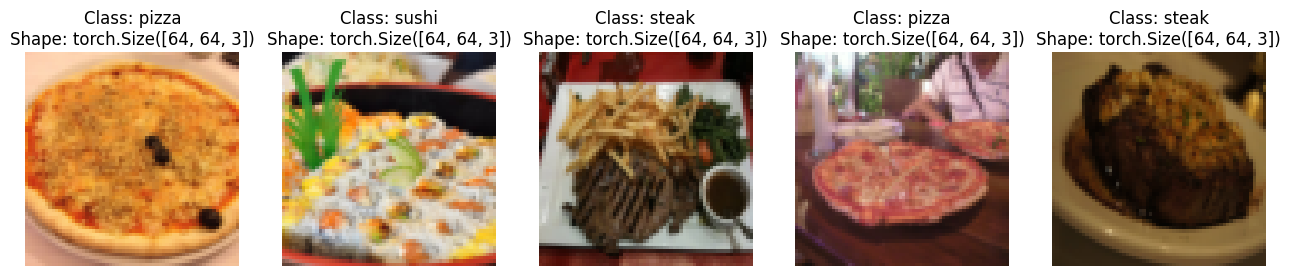

In [37]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom, n=5, 
                      classes=class_names, seed=None)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [38]:
# Turn train and test datsets into DataLoader's 
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x787a3982bee0>,
 <torch.utils.data.dataloader.DataLoader at 0x787a3934f6a0>)

In [39]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

In [40]:
# Trivailaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [41]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('/kaggle/working/pizza-steak-sushi/test/steak/1882831.jpg'),
 PosixPath('/kaggle/working/pizza-steak-sushi/test/steak/1285886.jpg'),
 PosixPath('/kaggle/working/pizza-steak-sushi/test/steak/354513.jpg'),
 PosixPath('/kaggle/working/pizza-steak-sushi/test/steak/894825.jpg'),
 PosixPath('/kaggle/working/pizza-steak-sushi/test/steak/966174.jpg'),
 PosixPath('/kaggle/working/pizza-steak-sushi/test/steak/3873283.jpg'),
 PosixPath('/kaggle/working/pizza-steak-sushi/test/steak/673127.jpg'),
 PosixPath('/kaggle/working/pizza-steak-sushi/test/steak/690177.jpg'),
 PosixPath('/kaggle/working/pizza-steak-sushi/test/steak/27415.jpg'),
 PosixPath('/kaggle/working/pizza-steak-sushi/test/steak/296375.jpg')]

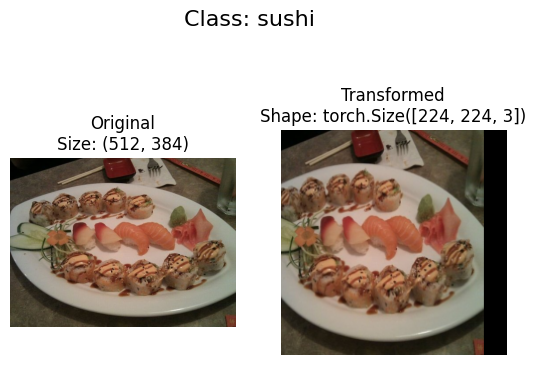

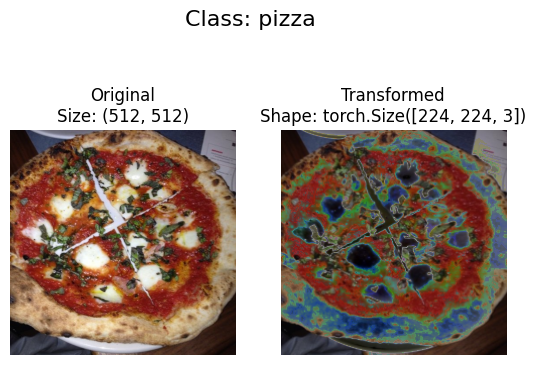

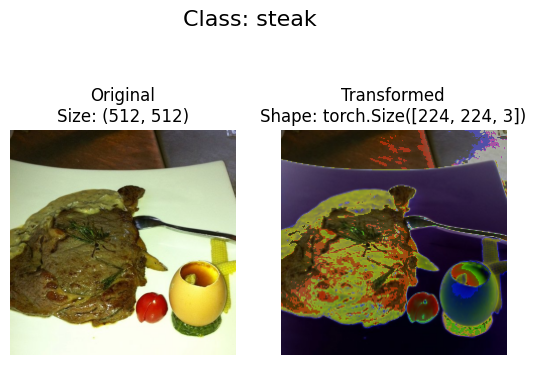

In [42]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform, n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [43]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [44]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False, 
                                     num_workers=NUM_WORKERS)

In [45]:
NUM_WORKERS

4

### 7.2 Create TinyVGG model class

In [46]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explanier
    """

    def __init__(self, 
                 input_shape: int,
                 hidden_shape: int,
                 output_shape: int) -> None:
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_shape,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_shape,
                      out_channels=hidden_shape,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_shape, 
                      out_channels=hidden_shape,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_shape,
                      out_channels=hidden_shape,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_shape*13*13,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [47]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3, 
                  hidden_shape=10, 
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [48]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [49]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0047e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.3248e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [50]:
# Install torchinfo import if it's available
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

In [51]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
  
  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader) 
  return train_loss, train_acc 

In [52]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader): 
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train_step()` and `test_step()`

In [53]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5, 
          device=device):
  
  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate Model 0

In [54]:
# Set random seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_shape=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f'Total training time: {end_time-start_time:3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0809 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0846 | Train acc: 0.3984 | Test loss: 1.0606 | Test acc: 0.5729
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4219 | Test loss: 1.0658 | Test acc: 0.5644
Total training time: 3.428736 seconds


### 7.8 Plot the loss curves of Model 0

In [55]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [56]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plot training curves of a results dictionary"""
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_acc')
    plt.plot(epochs, test_accuracy, label='test_acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

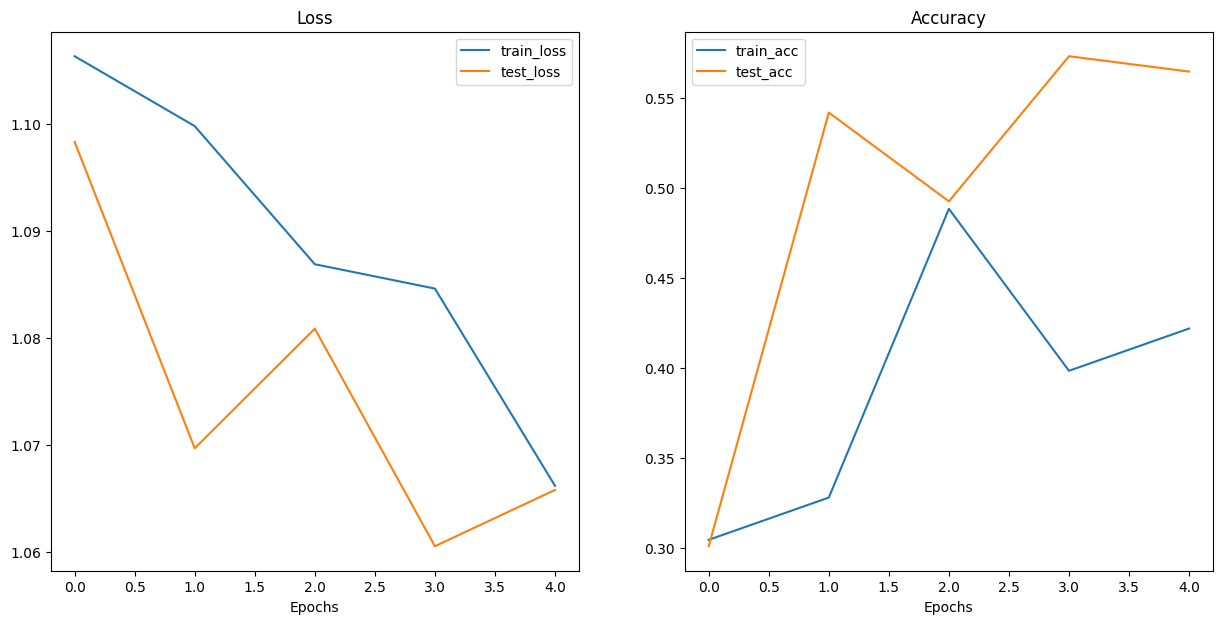

In [57]:
plot_loss_curves(model_0_results)